In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
!pip install ultralytics --quiet
from ultralytics import YOLO


In [ ]:
import os
import shutil
import random
from glob import glob
from tqdm import tqdm

original_images = "/content/drive/MyDrive/cell-count/train/original"
original_masks = "/content/drive/MyDrive/cell-count/train/mask"

base_path = "/content/yolo_dataset"
splits = ["train", "val"]
for split in splits:
    os.makedirs(f"{base_path}/images/{split}", exist_ok=True)
    os.makedirs(f"{base_path}/masks/{split}", exist_ok=True)
    os.makedirs(f"{base_path}/labels/{split}", exist_ok=True)

image_paths = sorted(glob(os.path.join(original_images, "*.png")))
random.shuffle(image_paths)

split_idx = int(0.9 * len(image_paths))
split_data = {
    "train": image_paths[:split_idx],
    "val": image_paths[split_idx:]
}


for split, files in split_data.items():
    for img_path in tqdm(files, desc=f"Copying {split} set"):
        fname = os.path.basename(img_path)
        mask_path = os.path.join(original_masks, fname)

        if not os.path.exists(mask_path):
            print(f" Mask not found for {fname}, skipping")
            continue

        shutil.copy(img_path, f"{base_path}/images/{split}/{fname}")
        shutil.copy(mask_path, f"{base_path}/masks/{split}/{fname}")


Copying val set: 100%|██████████| 107/107 [00:39<00:00,  2.69it/s]


In [ ]:
import cv2
import numpy as np
from tqdm import tqdm
import os

def normalize_bbox(x, y, w, h, img_w, img_h):
    x_center = (x + w / 2) / img_w
    y_center = (y + h / 2) / img_h
    return x_center, y_center, w / img_w, h / img_h

for split in ["train", "val"]:
    image_dir = f"/content/yolo_dataset/images/{split}"
    mask_dir = f"/content/yolo_dataset/masks/{split}"
    label_dir = f"/content/yolo_dataset/labels/{split}"

    os.makedirs(label_dir, exist_ok=True)
    image_files = sorted(os.listdir(image_dir))

    for filename in tqdm(image_files, desc=f"Generating labels for {split}"):
        mask_path = os.path.join(mask_dir, filename)
        image_path = os.path.join(image_dir, filename)
        label_path = os.path.join(label_dir, filename.rsplit(".", 1)[0] + ".txt")

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            continue

        h, w = mask.shape[:2]
        thresh = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)[1]
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        yolo_lines = []
        for cnt in contours:
            x, y, bw, bh = cv2.boundingRect(cnt)
            if bw < 5 or bh < 5:
                continue
            x_c, y_c, norm_w, norm_h = normalize_bbox(x, y, bw, bh, w, h)
            yolo_lines.append(f"0 {x_c:.6f} {y_c:.6f} {norm_w:.6f} {norm_h:.6f}")

        with open(label_path, "w") as f:
            f.write("\n".join(yolo_lines))


Generating labels for val: 100%|██████████| 107/107 [00:02<00:00, 45.20it/s]


In [ ]:
yaml_content = """
train: /content/yolo_dataset/images/train
val: /content/yolo_dataset/images/val

nc: 1
names: ['cell']
"""

with open("/content/dataset.yaml", "w") as f:
    f.write(yaml_content.strip())


In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.yaml")
model.train(data="/content/dataset.yaml", epochs=25, imgsz=640, batch=8)


Ultralytics 8.3.98 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/dataset.yaml, epochs=25, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, s

100%|██████████| 5.35M/5.35M [00:00<00:00, 93.3MB/s]


AMP: checks passed ✅


train: Scanning /content/yolo_dataset/labels/train... 956 images, 0 backgrounds, 0 corrupt: 100%|██████████| 956/956 [00:01<00:00, 498.60it/s]

train: New cache created: /content/yolo_dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/yolo_dataset/labels/val... 107 images, 0 backgrounds, 0 corrupt: 100%|██████████| 107/107 [00:00<00:00, 396.96it/s]

val: New cache created: /content/yolo_dataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      3.79G      4.104      2.152      3.292        380        640: 100%|██████████| 120/120 [00:13<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.34it/s]

                   all        107       7659      0.878      0.765      0.842        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      4.64G      1.676     0.8706      1.662        552        640: 100%|██████████| 120/120 [00:11<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.33it/s]

                   all        107       7659      0.908      0.916      0.963      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      4.64G      1.293     0.7259      1.305        279        640: 100%|██████████| 120/120 [00:11<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]

                   all        107       7659      0.886      0.898      0.956      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      4.66G      1.146     0.6712      1.202        295        640: 100%|██████████| 120/120 [00:11<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.58it/s]

                   all        107       7659      0.921      0.929      0.974      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      5.19G      1.053     0.6228       1.14        502        640: 100%|██████████| 120/120 [00:11<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]

                   all        107       7659      0.921      0.918      0.974      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      5.21G     0.9679     0.5935      1.101        552        640: 100%|██████████| 120/120 [00:11<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]

                   all        107       7659      0.924      0.918       0.97      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      5.22G     0.9592     0.5808      1.075        571        640: 100%|██████████| 120/120 [00:11<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]

                   all        107       7659      0.946      0.921      0.976       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      5.24G     0.8898     0.5545      1.051        327        640: 100%|██████████| 120/120 [00:11<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]

                   all        107       7659       0.94      0.929      0.979      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      5.26G     0.8489     0.5259      1.024        286        640: 100%|██████████| 120/120 [00:11<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.08it/s]

                   all        107       7659      0.938      0.935      0.978      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      5.28G     0.8435      0.524      1.021        416        640: 100%|██████████| 120/120 [00:11<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.96it/s]


                   all        107       7659      0.938       0.93      0.978      0.807

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      5.29G     0.8149     0.5062      1.002        433        640: 100%|██████████| 120/120 [00:11<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.21it/s]

                   all        107       7659      0.937       0.94      0.978      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      5.31G      0.784      0.491     0.9915        536        640: 100%|██████████| 120/120 [00:11<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]

                   all        107       7659      0.946       0.94      0.981      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      5.32G     0.7792     0.4898     0.9853        318        640: 100%|██████████| 120/120 [00:11<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.81it/s]


                   all        107       7659      0.944      0.944      0.982      0.823

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      5.35G     0.7801     0.4799      0.975        378        640: 100%|██████████| 120/120 [00:11<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.02it/s]

                   all        107       7659      0.945      0.934      0.979      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      5.36G     0.7716     0.4777     0.9715        312        640: 100%|██████████| 120/120 [00:11<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]

                   all        107       7659      0.951      0.935      0.981      0.832


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      5.38G     0.7187     0.4869     0.9509        297        640: 100%|██████████| 120/120 [00:12<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


                   all        107       7659       0.94      0.949      0.982      0.831

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      5.39G     0.6962     0.4602     0.9487        194        640: 100%|██████████| 120/120 [00:11<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.04it/s]

                   all        107       7659      0.939      0.947      0.982      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      5.41G     0.6911     0.4571     0.9445        253        640: 100%|██████████| 120/120 [00:11<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  9.23it/s]


                   all        107       7659      0.948      0.941      0.982      0.827

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      5.43G     0.6825     0.4484     0.9447        205        640: 100%|██████████| 120/120 [00:11<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]

                   all        107       7659      0.947      0.948      0.983      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      5.45G     0.6616     0.4422     0.9381        324        640: 100%|██████████| 120/120 [00:11<00:00, 10.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]

                   all        107       7659       0.94       0.95      0.982      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      5.46G     0.6509     0.4372     0.9368        195        640: 100%|██████████| 120/120 [00:11<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.12it/s]

                   all        107       7659      0.944       0.95      0.983      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      5.48G      0.642     0.4261     0.9257        248        640: 100%|██████████| 120/120 [00:11<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.43it/s]

                   all        107       7659      0.946      0.951      0.985       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      5.49G     0.6312     0.4204     0.9234        273        640: 100%|██████████| 120/120 [00:11<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.66it/s]

                   all        107       7659      0.944      0.949      0.983      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      5.51G     0.6296     0.4193     0.9264        232        640: 100%|██████████| 120/120 [00:11<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  8.95it/s]

                   all        107       7659      0.942       0.95      0.983      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      5.53G     0.6254     0.4129      0.917        257        640: 100%|██████████| 120/120 [00:11<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  9.88it/s]

                   all        107       7659      0.945      0.949      0.984       0.85



25 epochs completed in 0.091 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.98 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.14it/s]


                   all        107       7659      0.942       0.95      0.983      0.851
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c9f0439f750>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

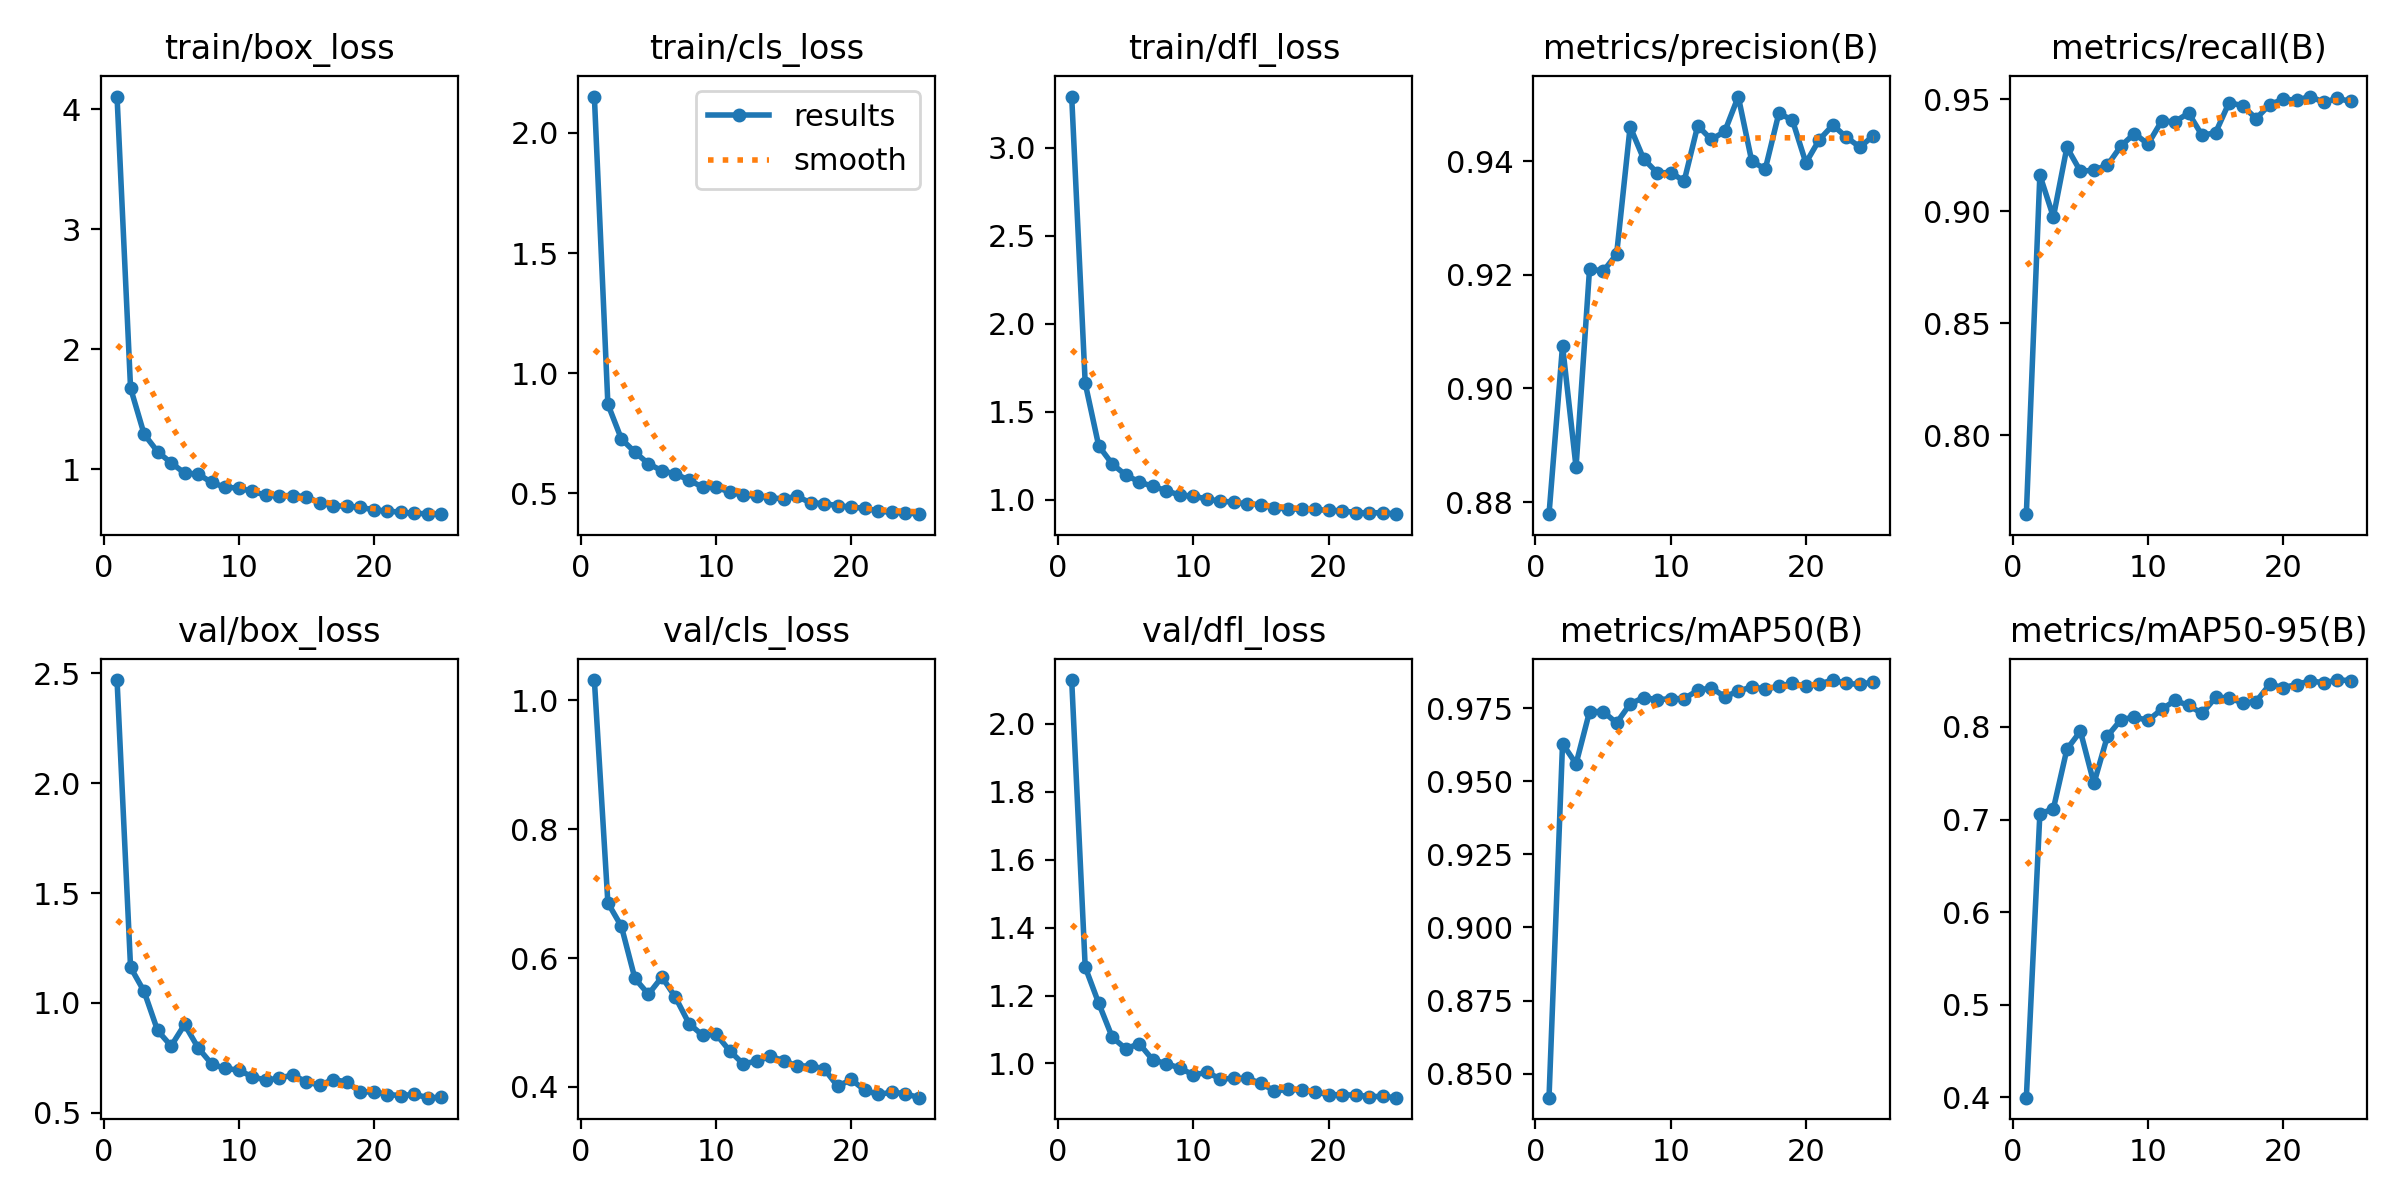

In [ ]:
from IPython.display import Image
Image(filename='runs/detect/train/labels.jpg')
Image(filename='runs/detect/train/results.png')


In [ ]:
val_image_path = "/content/yolo_dataset/images/val"
results = model.predict(val_image_path, save=True, conf=0.25)



image 1/107 /content/yolo_dataset/images/val/00d04a90-80e5-4bce-9511-1b64eabb7a47.png: 480x640 161 cells, 47.1ms
image 2/107 /content/yolo_dataset/images/val/035f6c4b-0897-46ab-9c3b-5f3b0feff043.png: 480x640 59 cells, 8.4ms
image 3/107 /content/yolo_dataset/images/val/036e008f-07a1-4e92-899d-1822dc390ccb.png: 480x640 60 cells, 8.6ms
image 4/107 /content/yolo_dataset/images/val/06cd484f-e864-4fee-8819-688b45eed98e.png: 480x640 70 cells, 8.1ms
image 5/107 /content/yolo_dataset/images/val/0ab56f9a-846d-49e2-a617-c6cc477fdfad.png: 480x640 55 cells, 7.9ms
image 6/107 /content/yolo_dataset/images/val/0fa5b35d-6c44-4207-b6f8-d5b355086b5f.png: 480x640 79 cells, 7.9ms
image 7/107 /content/yolo_dataset/images/val/1345dc89-a3d9-4b71-8a75-b3bff01ba518.png: 480x640 34 cells, 8.0ms
image 8/107 /content/yolo_dataset/images/val/137d540f-d71e-47e8-bd9b-6cd0a6433c33.png: 480x640 61 cells, 7.7ms
image 9/107 /content/yolo_dataset/images/val/14b68d86-ac7f-419d-b4a5-6b0b1d9aaa18.png: 480x640 114 cells, 8.0

In [ ]:
val_path = "/content/yolo_dataset/images/val"

results = model.predict(source=val_path, save=True, conf=0.25)




image 1/107 /content/yolo_dataset/images/val/00d04a90-80e5-4bce-9511-1b64eabb7a47.png: 480x640 161 cells, 9.9ms
image 2/107 /content/yolo_dataset/images/val/035f6c4b-0897-46ab-9c3b-5f3b0feff043.png: 480x640 59 cells, 8.4ms
image 3/107 /content/yolo_dataset/images/val/036e008f-07a1-4e92-899d-1822dc390ccb.png: 480x640 60 cells, 8.1ms
image 4/107 /content/yolo_dataset/images/val/06cd484f-e864-4fee-8819-688b45eed98e.png: 480x640 70 cells, 8.5ms
image 5/107 /content/yolo_dataset/images/val/0ab56f9a-846d-49e2-a617-c6cc477fdfad.png: 480x640 55 cells, 8.2ms
image 6/107 /content/yolo_dataset/images/val/0fa5b35d-6c44-4207-b6f8-d5b355086b5f.png: 480x640 79 cells, 8.4ms
image 7/107 /content/yolo_dataset/images/val/1345dc89-a3d9-4b71-8a75-b3bff01ba518.png: 480x640 34 cells, 8.3ms
image 8/107 /content/yolo_dataset/images/val/137d540f-d71e-47e8-bd9b-6cd0a6433c33.png: 480x640 61 cells, 8.4ms
image 9/107 /content/yolo_dataset/images/val/14b68d86-ac7f-419d-b4a5-6b0b1d9aaa18.png: 480x640 114 cells, 9.3m

In [ ]:
import os
import csv
from ultralytics import YOLO

# Load your trained model
model = YOLO("runs/detect/train/weights/best.pt")

# Path to val images
val_dir = "/content/yolo_dataset/images/val"
image_files = sorted([f for f in os.listdir(val_dir) if f.endswith(".png")])

# Output CSV
output_path = "/content/cell_measurements.csv"
with open(output_path, mode="w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Image", "CellID", "MajorAxisLength", "MinorAxisLength"])

    for image_name in image_files:
        results = model.predict(source=os.path.join(val_dir, image_name), conf=0.25, verbose=False)
        boxes = results[0].boxes.xywh  # x_center, y_center, width, height

        for i, box in enumerate(boxes):
            _, _, w, h = box
            w, h = float(w), float(h)
            major = max(w, h)
            minor = min(w, h)
            writer.writerow([image_name, i + 1, major, minor])


In [ ]:
import pandas as pd

# Load the CSV
df = pd.read_csv("/content/cell_measurements.csv")

# Total cell count
total_cells = len(df)

# Summary stats
major_mean = df["MajorAxisLength"].mean()
major_std = df["MajorAxisLength"].std()
minor_mean = df["MinorAxisLength"].mean()
minor_std = df["MinorAxisLength"].std()

print(f"Total cells detected: {total_cells}")
print(f"Major Axis: Mean = {major_mean:.2f}, Std = {major_std:.2f}")
print(f"Minor Axis: Mean = {minor_mean:.2f}, Std = {minor_std:.2f}")


Total cells detected: 8775
Major Axis: Mean = 111.04, Std = 18.04
Minor Axis: Mean = 92.05, Std = 22.00


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"


!zip -r /content/yolo_results.zip /content/runs /content/yolo_dataset /content/cell_measurements.csv /content/dataset.yaml
from google.colab import files
files.download("/content/yolo_results.zip")
!cp /content/yolo_results.zip /content/drive/MyDrive/


  adding: content/runs/ (stored 0%)
  adding: content/runs/detect/ (stored 0%)
  adding: content/runs/detect/train/ (stored 0%)
  adding: content/runs/detect/train/PR_curve.png (deflated 25%)
  adding: content/runs/detect/train/val_batch2_pred.jpg (deflated 3%)
  adding: content/runs/detect/train/val_batch2_labels.jpg (deflated 4%)
  adding: content/runs/detect/train/args.yaml (deflated 53%)
  adding: content/runs/detect/train/train_batch1800.jpg (deflated 7%)
  adding: content/runs/detect/train/train_batch0.jpg (deflated 5%)
  adding: content/runs/detect/train/weights/ (stored 0%)
  adding: content/runs/detect/train/weights/last.pt (deflated 11%)
  adding: content/runs/detect/train/weights/best.pt (deflated 11%)
  adding: content/runs/detect/train/val_batch0_pred.jpg (deflated 3%)
  adding: content/runs/detect/train/train_batch1801.jpg (deflated 6%)
  adding: content/runs/detect/train/train_batch1802.jpg (deflated 7%)
  adding: content/runs/detect/train/val_batch1_pred.jpg (deflated 3

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>